In [1]:
'''
 # @ Author: Mitas Ray
 # @ Create Time: 2022-01-13 17:44:00
 # @ Description: This file implements functions from the pricing module
 # to show how to get the price and yield of a trade.
 '''

import numpy as np
import os
from google.cloud import bigquery

from ficc.utils.auxiliary_functions import sqltodf
from ficc.pricing.auxiliary_functions import transform_reference_data
from ficc.pricing.price import compute_price
from ficc.pricing.yield_rate import compute_yield

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../ficc/creds.json"    # put the location of your `creds.json` file

### Conditions that we tested on:
* `yield > 0`: conceptually, this notebook should work for any yield, but in practice, bonds with zero yield indicates a problem with MSRB data, and negative yields haven't been tested on
* `is_non_transaction_based_compensation is false`, `is_lop_or_takedown is false`: conceptually, this notebook should work without these filters, but in practice, away from market prices sometimes have anomolous yields reported in the MSRB data
* `callable_at_cav is false`: this notebook will not be correct for bonds callable at cav; future work will incorporate the special case of cav bonds that have call prices from ICE data
* `ice_valid_TO_date > timestamp(publish_datetime, "America/New_York")`, `timestamp(publish_datetime, "America/New_York") >= ice_valid_from_date`, `msrb_valid_to_date > publish_datetime`, `msrb_valid_from_date <= publish_datetime`: conditions to correctly join ICE and MSRB
* `par_call_price = 100`: conceptually this is identical to the fourth bullet point, but sometimes there are issues in the ICE data
* `interest_payment_frequency is not NULL`: if interest payment frequency is NULL, then the coupon frequency is unknown; possibly the field `coupon_type` could be used to determine the interest payment frequency

In [3]:
query = lambda trade_date: ''' SELECT
                                IFNULL(settlement_date, assumed_settlement_date) AS settlement_date,
                                trade_date,
                                cusip,
                                accrual_date,
                                dollar_price,
                                issue_price,
                                coupon,
                                interest_payment_frequency,
                                next_call_date,
                                par_call_date,
                                next_call_price,
                                par_call_price,
                                maturity_date,
                                previous_coupon_payment_date,
                                next_coupon_payment_date,
                                first_coupon_date,
                                coupon_type,
                                muni_security_type,
                                called_redemption_type,
                                refund_date,
                                refund_price,
                                is_callable,
                                is_called,
                                call_timing,
                                yield,
                                called_redemption_date,
                                rtrs_control_number,
                                has_zero_coupons,
                                last_period_accrues_from_date
                            FROM 
                                `eng-reactor-287421.auxiliary_views.trades_with_ref_data_pd`
                            WHERE 
                                -- yield > 0 and
                                -- is_non_transaction_based_compensation is false and 
                                -- callable_at_cav is false and 
                                -- is_lop_or_takedown is false and 
                                ice_valid_TO_date > timestamp(publish_datetime, "America/New_York") and
                                timestamp(publish_datetime, "America/New_York") >= ice_valid_from_date and
                                msrb_valid_to_date > publish_datetime and
                                msrb_valid_from_date <= publish_datetime and
                                -- par_call_price is not NULL and
                                -- par_call_price = 100 and
                                -- interest_payment_frequency is not NULL and 
                                -- interest_payment_frequency = 16 and 
                                -- coupon > 0 and
                                trade_date = \'''' + trade_date + '''\'
                            '''

In [4]:
date = '2021-12-01'

In [5]:
bqclient = bigquery.Client()
muni_df = sqltodf(query(date), bqclient)
transform_reference_data(muni_df)

In [6]:
muni_df    # visualize the dataframe

,settlement_date,trade_date,cusip,accrual_date,dollar_price,issue_price,coupon,interest_payment_frequency,next_call_date,par_call_date,...,refund_price,is_callable,is_called,call_timing,yield,called_redemption_date,rtrs_control_number,has_zero_coupons,last_period_accrues_from_date,deferred
0,2021-12-03,2021-12-01,709224DH9,2014-04-29,112.110,109.011025,5.00,2,2024-12-01,2024-12-01,...,NaN,True,False,1.0,0.893,None,2021120105810500,False,2031-06-01,False
1,2021-12-03,2021-12-01,575579C21,2017-10-12,115.694,122.882978,5.00,2,None,None,...,NaN,False,False,NaN,0.563,None,2021120102335700,False,2025-01-01,False
2,2021-12-03,2021-12-01,684517PS8,2013-09-18,103.033,112.893946,5.00,2,None,None,...,NaN,False,False,NaN,0.401,None,2021120102858900,False,2022-02-01,False
3,2021-12-03,2021-12-01,684517PS8,2013-09-18,103.033,112.893946,5.00,2,None,None,...,NaN,False,False,NaN,0.401,None,2021120102858700,False,2022-02-01,False
4,2021-12-03,2021-12-01,59259RWP5,2005-07-01,108.880,115.158178,5.25,2,None,None,...,NaN,False,False,NaN,0.659,None,2021120103384200,False,2023-05-15,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30344,2021-12-03,2021-12-01,41423LHZ2,2021-10-20,93.247,97.332000,2.00,2,2026-09-01,2026-09-01,...,NaN,True,False,1.0,2.522,None,2021120104828100,False,2037-03-01,False
30345,2021-12-03,2021-12-01,837152UQ8,2017-07-27,122.144,116.756747,5.00,2,2027-10-01,2027-10-01,...,NaN,True,False,1.0,1.070,None,2021120103836200,False,2034-04-01,False
30346,2021-12-03,2021-12-01,837152UQ8,2017-07-27,121.639,116.756747,5.00,2,2027-10-01,2027-10-01,...,NaN,True,False,1.0,1.150,None,2021120105020400,False,2034-04-01,False
30347,2021-12-03,2021-12-01,721014NN4,2021-09-10,127.390,131.400709,5.00,2,None,None,...,NaN,False,False,NaN,1.172,None,2021120104321200,False,2028-12-01,False


Apply the `compute_price` function to every trade

In [7]:
muni_df['price_calc_from_yield'] = muni_df.apply(lambda x: compute_price(x), axis=1)

Plot the price from the reference data on the x-axis and our computed price on the y-axis

<AxesSubplot:xlabel='dollar_price', ylabel='price_from_yield'>

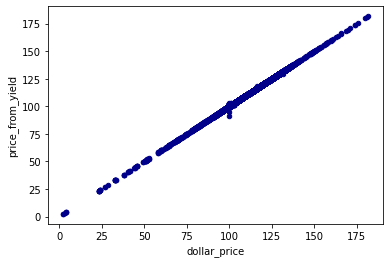

In [8]:
muni_df["price_from_yield"] = [x[0] for x in muni_df['price_calc_from_yield']]
muni_df.plot.scatter(x='dollar_price', y='price_from_yield', c='DarkBlue')

Return the sum and mean of the errors where the error is defined as the absolute distance between our computed price and the reference price

In [9]:
muni_df['price_delta'] = abs(muni_df['price_from_yield'] - muni_df['dollar_price'])
print("Sum of errors: {}".format(np.sum(muni_df['price_delta'])))
print("Mean of errors: {}".format(np.mean(muni_df['price_delta'])))

Sum of errors: 134.39799999999968
Mean of errors: 0.004428416092787231


Apply the `compute_yield` function to every trade

In [10]:
muni_df["yield_and_calc_date"] = muni_df.apply(lambda x: compute_yield(x), axis=1)

Plot the yield from the reference data on the x-axis and our computed yield on the y-axis

<AxesSubplot:xlabel='yield', ylabel='yield_from_price'>

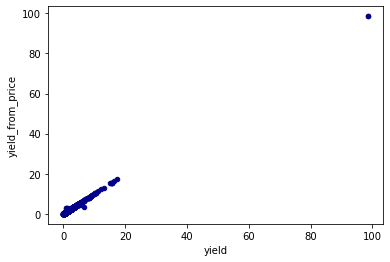

In [11]:
muni_df["yield_from_price"] = [x[0] for x in muni_df['yield_and_calc_date']]
muni_df["yield_calc_date"] = [x[1] for x in muni_df['yield_and_calc_date']]
# when we get close to redemption, it's difficult to compute the yield from the price
muni_df.plot.scatter(x='yield', y='yield_from_price', c='DarkBlue')

Return the sum and mean of the errors where the error is defined as the absolute distance between our computed yield and the reference yield

In [12]:
muni_df['ytw_delta'] = abs(muni_df['yield_from_price'] - muni_df['yield'])
print("Sum of errors: {}".format(np.sum(muni_df['ytw_delta'])))
print("Mean of errors: {}".format(np.mean(muni_df['ytw_delta'])))

Sum of errors: 24.03199999999999
Mean of errors: 0.00079185475633464
